In [7]:
# Switching kernel : rgan

In [8]:
import os
import time

import torch
from torch import nn, optim
from torch import cuda, device, utils
from torch.autograd import Variable

from torchsummary import summary
from torchvision import datasets, transforms

from module.layers import Gconv

import numpy as np
from pyntcloud import PyntCloud

from tqdm import tqdm

print(cuda.is_available())
device = device('cuda:0')
print(device)


True
cuda:0


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pcl(points, ax, nogrid):
    ax.patch.set_alpha(0)
    ax.set_xlim3d(-0.5, 0.5)
    ax.set_ylim3d(-0.5, 0.5)
    ax.set_zlim3d(-0.5, 0.5)
    ax.view_init(elev=60., azim=90.)
    if nogrid: ax.grid(False)
    ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,1], cmap='plasma', s=10)

def plot_pcls(pcls, nogrid=False, size=(16, 8)):
    fig = plt.figure(figsize=size)
    for i, pcl in enumerate(pcls):
        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        plot_pcl(pcl, ax, nogrid)

In [10]:
def ShapeNetLoader(path):
    cloud = PyntCloud.from_file(path)
    arr = np.array(cloud.points, dtype=np.float32).reshape(-1, 3)

    return arr

class PCLDataset(utils.data.Dataset):

    class Downsample(object):
        def __init__(self, factor):
            self.factor = factor
        
        def __call__(self, sample):
            sample_size = sample.shape[0] # 2048
            sample = sample[np.random.permutation(sample_size),:]
            return sample[np.arange(0, sample_size, self.factor), :]

    class FilterNan(object):
        def __call__(self, sample):
            sample[sample != sample] = 0 # since nan!=nan
            return sample
    
    class Normalize(object):        
        def __call__(self, sample):
            sample -= sample.min(0, keepdims=True)
            sample /= sample.max(0, keepdims=True)
            return sample

    class ToTensor(object):
        def __call__(self, sample):
            return torch.from_numpy(sample)
    
    def __init__(self, path, label, ext, ldr, fctr, lim=None):
        snc_synth_id_to_category = {
        'airplane' : '02691156', 'bag'        : '02773838', 'basket'        :'02801938',
        'bathtub'  : '02808440', 'bed'        : '02818832', 'bench'         :'02828884',
        'bicycle'  : '02834778', 'birdhouse'  : '02843684', 'bookshelf'     :'02871439',
        'bottle'   : '02876657', 'bowl'       : '02880940', 'bus'           :'02924116',
        'cabinet'  : '02933112', 'can'        : '02747177', 'camera'        :'02942699',
        'cap'      : '02954340', 'car'        : '02958343', 'chair'         :'03001627',
        'clock'    : '03046257', 'dishwasher' : '03207941', 'monitor'       :'03211117',
        'table'    : '04379243', 'telephone'  : '04401088', 'tin_can'       :'02946921',
        'tower'    : '04460130', 'train'      : '04468005', 'keyboard'      :'03085013',
        'earphone' : '03261776', 'faucet'     : '03325088', 'file'          :'03337140',
        'guitar'   : '03467517', 'helmet'     : '03513137', 'jar'           :'03593526',
        'knife'    : '03624134', 'lamp'       : '03636649', 'laptop'        :'03642806',
        'speaker'  : '03691459', 'mailbox'    : '03710193', 'microphone'    :'03759954',
        'microwave': '03761084', 'motorcycle' : '03790512', 'mug'           :'03797390',
        'piano'    : '03928116', 'pillow'     : '03938244', 'pistol'        :'03948459',
        'pot'      : '03991062', 'printer'    : '04004475', 'remote_control':'04074963',
        'rifle'    : '04090263', 'rocket'     : '04099429', 'skateboard'    :'04225987',
        'sofa'     : '04256520', 'stove'      : '04330267', 'vessel'        :'04530566',
        'washer'   : '04554684', 'boat'       : '02858304', 'cellphone'     :'02992529'
        }
        self.tsfm = transforms.Compose([self.Downsample(factor=fctr), self.ToTensor()])
        self.path = os.path.join(path, snc_synth_id_to_category[label])
        self.source = os.listdir(self.path)
        self.size = len(self.source) if lim == None else lim
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data = ShapeNetLoader(os.path.join(self.path, self.source[idx])).transpose(0,1)
        return self.tsfm(data)

In [11]:
class DecoderGCN(nn.Module):
    def __init__(self, nc, nf, nz):
        super(DecoderGCN, self).__init__()
        feat_dim = [nz,nf,48,32,16,3]
        pt_num = [1,8,32,128,512]

        self.gconv_net = nn.Sequential(
                         Gconv(feat_dim[0], feat_dim[1], pt_num[0], K=2, up_ftr=8),
                         nn.ReLU(True),
                         Gconv(feat_dim[1], feat_dim[2], pt_num[1], K=4, up_ftr=4),
                         nn.ReLU(True),
                         Gconv(feat_dim[2], feat_dim[3], pt_num[2], K=6, up_ftr=4),
                         nn.ReLU(True),
                         Gconv(feat_dim[3], feat_dim[4], pt_num[3], K=8, up_ftr=4),
                         nn.ReLU(True))

        self.dense_net = nn.Linear(pt_num[-1]*feat_dim[-2], pt_num[-1]*feat_dim[-1])

    def forward(self, input):
        feat = self.gconv_net(input)
        feat = self.dense_net(feat)
        feat = feat.reshape(feat.size(0),-1,3)

        return feat
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)
            

In [12]:
class Discriminator(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Discriminator, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(nc, nf),
            nn.LeakyReLU(0.1),

            nn.Linear(nf, 128),
            nn.LeakyReLU(0.1),

            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),

            nn.Linear(256, 256),
            nn.LeakyReLU(0.1),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1)
        )
        self.dec = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, nf),
            nn.ReLU(True),
            nn.Linear(nf, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        z = self.enc(input)
        z_max, _ = torch.max(z, dim=1)
        prob = self.dec(z_max)
        return prob
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)
        if classname.find('Linear') != -1:
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)

In [13]:
nz = 128
nf = 96
nc = 3
mu = 0.
sigma = 0.2
batch_size = 50 # Argument
down_fctr = 4 # Argument
point_num = int(2048 / down_fctr) # Argument

dec = DecoderGCN(nc=nc, nf=nf, nz=nz).to(device)
dec.apply(dec.weights_init)
z = torch.FloatTensor(batch_size, nz).normal_(0, 0.2).to(device)
print(z.shape)
print(dec(z).shape)
summary(dec, (1, nz))

dis = Discriminator(nc=nc, nf=nf, nz=nz).to(device)
dis.apply(dis.weights_init)
y = Variable(torch.ones((batch_size, point_num, nc)).to(device))
print(y.shape)
prob = dis(y)
print(prob.shape)
summary(dis, (1, point_num, nc))


torch.Size([50, 128])
torch.Size([50, 512, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 768]          99,072
  GraphConvolution-2                [-1, 96, 8]           9,312
             Gconv-3                  [-1, 768]               0
              ReLU-4                  [-1, 768]               0
            Linear-5                 [-1, 1536]       1,181,184
  GraphConvolution-6               [-1, 48, 32]           2,352
             Gconv-7                 [-1, 1536]               0
              ReLU-8                 [-1, 1536]               0
            Linear-9                 [-1, 4096]       6,295,552
 GraphConvolution-10              [-1, 32, 128]           1,056
            Gconv-11                 [-1, 4096]               0
             ReLU-12                 [-1, 4096]               0
           Linear-13                 [-1, 8192]      33,

In [14]:
root = os.path.abspath(os.getcwd())
print(root)
shapenet_path = 'data/shape_net_core_uniform_samples_2048/'
shape_label = 'airplane' # Argument

dataset = PCLDataset(os.path.join(root, shapenet_path), label=shape_label, ext='.ply', ldr=ShapeNetLoader, fctr=down_fctr, lim=None)
dataloader = utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print('Batch size: ', batch_size)
print('Number of batches:', len(dataloader))

c:\Users\SEO\Desktop\samsumg_practice\gnn_practice\knn_gan
Batch size:  50
Number of batches: 80


torch.Size([50, 512, 3])


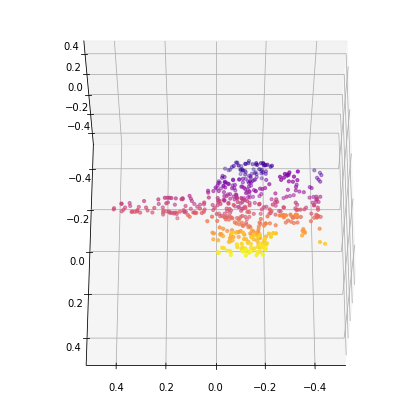

In [15]:
idx, (dataA) = next(enumerate(dataloader))
x = Variable(dataA).to(device)
print(x.shape)
plot_pcls([x.cpu().detach().numpy()[0]])

In [16]:
lrg = 1e-4
lrd = 1e-4
b1 = 0.5
b2 = 0.999
wd = 1e-3

optimizer_gen = optim.Adam(params=dec.parameters(), lr=lrg, betas=(b1, b2))
optimizer_dis = optim.Adam(params=dis.parameters(), lr=lrd, betas=(b1, b2))

criterion_adv = nn.BCELoss().to(device) 

class GenLoss(nn.Module):
    def __init__(self):
        super(GenLoss, self).__init__()

    def __call__(self, synt):
        return torch.mean(-torch.log(synt)) 

criterion_gen = GenLoss().to(device)

class DisLoss(nn.Module):
    def __init__(self):
        super(DisLoss, self).__init__()

    def __call__(self, real, synt):
        return torch.mean(-torch.log(real) - torch.log(1 - synt))

criterion_dis = DisLoss().to(device)


In [17]:
epochs = 200

gen_losses = []
dis_losses = []

for epoch in range(1, epochs + 1):
    progress_dataloader = tqdm(dataloader)
    for idx, pc in enumerate(progress_dataloader):
        batch_size = pc.shape[0]
        
        x = Variable(pc).to(device)
        z = torch.FloatTensor(batch_size, nz).normal_(0., 0.2).to(device)
        rec = dec(z)
        
        prob_x = dis(x)
        prob_rec = dis(rec)
        prob_real = Variable(torch.ones((batch_size, 1)).to(device))
        prob_fake = Variable(torch.zeros((batch_size, 1)).to(device))

        # Update Discriminator
        optimizer_dis.zero_grad()
        dis_real_loss = criterion_adv(prob_x, prob_real)
        dis_rec_loss = criterion_adv(prob_rec, prob_fake)
        dis_loss = dis_real_loss + dis_rec_loss

        dis_loss.backward(retain_graph=True)
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())

        # Update Generator
        prob_rec = dis(rec)
        optimizer_gen.zero_grad()
        gen_loss = criterion_adv(prob_rec, prob_real)
        gen_loss.backward()
        optimizer_gen.step()
        gen_losses.append(gen_loss.item())
        
        progress_dataloader.set_description('[%d/%d;%d/%d]: gen_loss: %.3f, dis_loss: %.3f'
              % (idx+1, len(dataloader), (epoch), epochs, 
                 torch.mean(torch.FloatTensor(gen_losses)),
                 torch.mean(torch.FloatTensor(dis_losses))))

    plot_pcls([x[0].cpu().detach().numpy(), rec[0].cpu().detach().numpy()])
    plt.savefig('iter_result.png')
    plt.close('all')
    

  0%|          | 0/80 [00:00<?, ?it/s]


RuntimeError: Function BmmBackward0 returned an invalid gradient at index 0 - expected type TensorOptions(dtype=float, device=cuda:0, layout=Sparse, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) but got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt))

In [ ]:
def running_mean(data_set, periods=10):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

rm_gen = running_mean(np.asarray(gen_losses))
rm_dis = running_mean(np.asarray(dis_losses))
plt.plot(range(0, len(rm_gen)), rm_gen, 'r-', label='Generator')
plt.plot(range(0, len(rm_dis)), rm_dis, 'b-', label='Discriminator')
plt.gca().patch.set_alpha(0)
plt.gcf().set_size_inches(8,4)
plt.title('Total Losses')
plt.legend()
plt.show()

In [ ]:
idx, (dataA) = next(enumerate(dataloader))
x = Variable(dataA).to(device)
# rec = decS(encS(x))
# visu_pcl(x.cpu().detach().numpy()[0].transpose(1,0), rec.cpu().detach().numpy()[0].transpose(1,0))
# visu_pcl(x.cpu().detach().numpy()[1].transpose(1,0), rec.cpu().detach().numpy()[1].transpose(1,0))
z = torch.Tensor(4, nz).normal_(0., 0.2).to(device)
rec = dec(z)
# print(rec)
print(rec.shape)
plot_pcls([x.cpu().detach().numpy()[0], rec.cpu().detach().numpy()[0]])
plot_pcls([x.cpu().detach().numpy()[1], rec.cpu().detach().numpy()[1]])
plot_pcls([x.cpu().detach().numpy()[2], rec.cpu().detach().numpy()[2]])
plot_pcls([x.cpu().detach().numpy()[3], rec.cpu().detach().numpy()[3]])